<a href="https://colab.research.google.com/github/ggrindstaff/Texas-2021/blob/master/MCMC_for_Texas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MCMC for Texas

Here we demonstrate the Markov Chain Monte Carlo analysis with Gerrychain used in [white paper linked here]. Please make a copy before testing it out!

## Load data and packages

Gerrychain is not installed on Colab, so first we have to install it.

In [1]:
!pip install gerrychain
!pip install tqdm

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 972kB 5.3MB/s 
     |████████████████████████████████| 14.8MB 312kB/s 
     |████████████████████████████████| 6.5MB 43.3MB/s 


Import statements - the rest of the packages should already be available

In [2]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from functools import partial
import pandas
import geopandas as gpd
import numpy


We download a shape file of Texas precinct data. These data are the voter tabulation districts (VTDs) defined by the 2010 Census, with demographic data, vote histories, and assignments to various electoral and functional districts. For more information, see http://www.ma.utexas.edu/users/gillian.grindstaff/TX_vtds_readme.txt. This shape file will be used to create the adjacency graph.

In [3]:
!wget http://www.ma.utexas.edu/users/gillian.grindstaff/TX_vtds_extra.zip
!unzip TX_vtds_extra.zip

--2020-11-20 04:07:13--  http://www.ma.utexas.edu/users/gillian.grindstaff/TX_vtds_extra.zip
Resolving www.ma.utexas.edu (www.ma.utexas.edu)... 146.6.224.236
Connecting to www.ma.utexas.edu (www.ma.utexas.edu)|146.6.224.236|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ma.utexas.edu/users/gillian.grindstaff/TX_vtds_extra.zip [following]
--2020-11-20 04:07:14--  https://www.ma.utexas.edu/users/gillian.grindstaff/TX_vtds_extra.zip
Connecting to www.ma.utexas.edu (www.ma.utexas.edu)|146.6.224.236|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://web.ma.utexas.edu/users/gillian.grindstaff/TX_vtds_extra.zip [following]
--2020-11-20 04:07:14--  https://web.ma.utexas.edu/users/gillian.grindstaff/TX_vtds_extra.zip
Resolving web.ma.utexas.edu (web.ma.utexas.edu)... 146.6.139.68
Connecting to web.ma.utexas.edu (web.ma.utexas.edu)|146.6.139.68|:443... connected.
HTTP request sent, awaiting res

This code will load the demographic and political boundary information attached to the shape file into a geodataframe. The code below takes a minute or two. We buffer to avoid topology errors.

In [4]:
df = gpd.read_file("/content/TX_vtds_extra.shp")
df.geometry = df.geometry.buffer(0)
df.head()

,CNTYVTD,VTD,WHITE,OTHER,HISPANIC,TOTPOP,VAP,BLACK,BLKHISP,WVAP,HISPVAP,BHVAP,BVAP,OTHVAP,COUNTY,FIPS,PRES12R,PRES12D,SEN12R,SEN12D,TOTVR12,TOTTO12,SEN14R,SEN14D,GOV14R,GOV14D,TOTVR14,TOTTO14,PRES16D,PRES16R,TOTVR16,TOTTO16,USCD,SEND,HD,AREA,PERIM,PLANC185,SD,18TotalPop,18TotalVR,18TotalTO,GOV18D,GOV18R,SEN18D,SEN18R,HISP18,18SpanSur,geometry
0,10001,0001,2053.0,89.0,401.0,3131.0,2341.0,606.0,989.0,1677.0,217.0,592.0,378.0,72.0,Anderson,1,754,261,713,285,1629,1026,441,110,424,130,1712,576,262,742,1799,1030,05,3,8,6,15,5,001907,3131.0,1802.0,926.0,214.0,699.0,261.0,659.0,144.160,8.0,"POLYGON ((1413960.808 1073012.816, 1413971.571..."
1,10002,0002,3171.0,64.0,245.0,3744.0,2732.0,272.0,509.0,2365.0,135.0,327.0,197.0,40.0,Anderson,1,1179,228,1072,274,2224,1418,677,80,663,110,2389,786,181,1318,2455,1532,05,3,8,259,95,5,001903,3744.0,2512.0,1237.0,134.0,1090.0,168.0,1062.0,87.920,3.5,"POLYGON ((1420165.429 1066385.798, 1420251.968..."
2,10003,0003,1443.0,32.0,151.0,1766.0,1345.0,140.0,291.0,1134.0,96.0,191.0,95.0,20.0,Anderson,1,650,108,607,126,1116,765,433,55,428,65,1137,498,94,663,1195,776,05,3,8,72,55,5,001903,1766.0,1195.0,675.0,80.0,593.0,99.0,571.0,51.385,4.3,"POLYGON ((1416275.023 1072178.732, 1416410.201..."
3,10004,0004,1962.0,40.0,78.0,2147.0,1684.0,72.0,145.0,1553.0,47.0,102.0,57.0,29.0,Anderson,1,729,128,675,155,1267,866,469,69,464,80,1399,556,96,869,1525,985,05,3,8,244,92,5,001909,2147.0,1567.0,853.0,77.0,767.0,97.0,752.0,40.742,2.6,"POLYGON ((1435604.819 1074650.256, 1435674.876..."
4,10005,0005,454.0,2.0,14.0,476.0,366.0,6.0,20.0,349.0,12.0,15.0,3.0,2.0,Anderson,1,174,13,152,29,269,188,120,1,124,2,276,129,9,180,282,191,05,3,8,171,87,5,001909,476.0,296.0,191.0,8.0,182.0,11.0,179.0,7.104,2.4,"POLYGON ((1436888.342 1072498.734, 1436911.364..."


## Initialize the Markov Chain

Forming the adjacency graph for Texas takes 3-7 minutes, since Texas is very big.

In [5]:
#cols = df.columns
#graph = Graph.from_geodataframe(df)
graph = Graph.from_geodataframe(df)

In [6]:
#Optional: this line fills empty spots (from discrepancies between 2010 and 2018 precincts) with 0
df.fillna(0)
graph.add_data(df)

/usr/local/lib/python3.6/dist-packages/gerrychain/graph/graph.py:261: UserWarning: NA values found in column 18TotalPop!
  warnings.warn("NA values found in column {}!".format(column))
/usr/local/lib/python3.6/dist-packages/gerrychain/graph/graph.py:261: UserWarning: NA values found in column 18TotalVR!
  warnings.warn("NA values found in column {}!".format(column))
/usr/local/lib/python3.6/dist-packages/gerrychain/graph/graph.py:261: UserWarning: NA values found in column 18TotalTO!
  warnings.warn("NA values found in column {}!".format(column))
/usr/local/lib/python3.6/dist-packages/gerrychain/graph/graph.py:261: UserWarning: NA values found in column GOV18D!
  warnings.warn("NA values found in column {}!".format(column))
/usr/local/lib/python3.6/dist-packages/gerrychain/graph/graph.py:261: UserWarning: NA values found in column GOV18R!
  warnings.warn("NA values found in column {}!".format(column))
/usr/local/lib/python3.6/dist-packages/gerrychain/graph/graph.py:261: UserWarning: NA

In [7]:
df.columns

Index(['CNTYVTD', 'VTD', 'WHITE', 'OTHER', 'HISPANIC', 'TOTPOP', 'VAP',
       'BLACK', 'BLKHISP', 'WVAP', 'HISPVAP', 'BHVAP', 'BVAP', 'OTHVAP',
       'COUNTY', 'FIPS', 'PRES12R', 'PRES12D', 'SEN12R', 'SEN12D', 'TOTVR12',
       'TOTTO12', 'SEN14R', 'SEN14D', 'GOV14R', 'GOV14D', 'TOTVR14', 'TOTTO14',
       'PRES16D', 'PRES16R', 'TOTVR16', 'TOTTO16', 'USCD', 'SEND', 'HD',
       'AREA', 'PERIM', 'PLANC185', 'SD', '18TotalPop', '18TotalVR',
       '18TotalTO', 'GOV18D', 'GOV18R', 'SEN18D', 'SEN18R', 'HISP18',
       '18SpanSur', 'geometry'],
      dtype='object')

Gerrychain has objects called "Election"s. Each takes two arguments - a name, and a dictionary of vote totals in different categories, here "Democratic" and "Republican" votes. The below code makes a list of Elections we will want to keep track of through the Markov chain. 

In [8]:
elections = [
    Election("GOV14", {"Democratic": "GOV14D", "Republican": "GOV14R"}),
    Election("SEN12", {"Democratic": "SEN12D", "Republican": "SEN12R"}),
    Election("SEN14", {"Democratic": "SEN14D", "Republican": "SEN14R"}),
    Election("SEN18", {"Democratic": "SEN18D", "Republican": "SEN18R"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "PRES16D", "Republican": "PRES16R"}),
    Election("GOV18", {"Democratic": "GOV18D", "Republican": "GOV18R"}),
]

Any information we would like to track through the Markov chain must be included as an "updater", which is another object of Gerrychain. 

In [9]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population"),
               "countysplits": updaters.county_splits("countysplits","COUNTY"),
               "WVAP":updaters.Tally("WVAP"),
               "VAP":updaters.Tally("VAP"),
               "HISPVAP":updaters.Tally("HISPVAP"),
               "BVAP":updaters.Tally("BVAP")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

Every Markov chain needs an initial position for the random walk. For ours, we use as initial partition the current US Congressional Districts, which the chain will randomly perturb. 

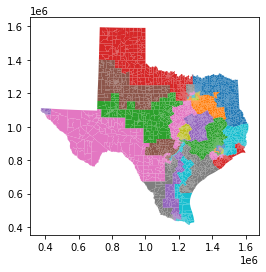

In [10]:
initial_partition = GeographicPartition(graph, assignment='USCD', updaters=my_updaters)
initial_partition.plot()

As an alternative to the above, we can create an initial partition from a Districtr file - first we upload the shape file and make it a graph (here TX_vtds was obtained from the same source as Districtr), and then we upload a json for assignments (export from Districtr to file repository, copy path as above)

In [11]:
#initial_partition = Partition.from_districtr_file(graph, districtr_file = filepath, updaters = my_updaters)

We set our ideal population to be the total population (sum of population in each district) divided by the number of districts - in this case, 36. GeographicPartition comes with built-in ``area`` and ``perimeter`` updaters. The recom proposal needs to know the ideal population for the districts so that
we can improve speed by discarding unbalanced partitions.

In [12]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
 of the recom proposal.

In [13]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.01,
                   node_repeats=2
                  )

We introduce two important constraints on plans.


1.   The number of cut edges (a discrete proxy for perimeter) is bounded to twice the cut edges in the original plan
2.   We create no new county splits - counties which are whole in the original plan must be kept whole



In [14]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

#split_bound = constraints.refuse_new_splits("countysplits")
split_bound = constraints.UpperBound(
    lambda p: len(p["countysplits"]),
    len(initial_partition["countysplits"])
)

Configure the Markov chain


1.   Choose number of steps n
2.   Configure MarkovChain object







In [15]:
n=200

In [16]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        # District populations must stay within 2% of equality
        constraints.within_percent_of_ideal_population(initial_partition, 0.01),
        compactness_bound,
        split_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=n
)

## Run the Chain

Before we officially run the chain, we create a few empty objects to store the data we'd like to track - here election results, non-white voting age population, and partisan gini scores, respectively.

In [17]:
election_data = pandas.DataFrame([],range(0,n),[election.name for election in elections])
demo_data = pandas.DataFrame([],range(0,n),["MVAP"])
HVAP_data = pandas.DataFrame([],range(0,n),["HISPVAP"])
BVAP_data = pandas.DataFrame([],range(0,n),["BVAP"])

#this will store the partisan gini scores for each plan, and each election
gini = []

i= 0

This loop actually runs the chain, and may take up to 15 or 20 minutes. As the chain iterates, we store the information we want to track in the dataframes just created. We may have nan errors from the 2018 data.

/usr/local/lib/python3.6/dist-packages/gerrychain/updaters/tally.py:35: UserWarning: ignoring nan encountered at node '22' for attribute 'Democratic'
  node, self.alias
/usr/local/lib/python3.6/dist-packages/gerrychain/updaters/tally.py:35: UserWarning: ignoring nan encountered at node '8914' for attribute 'Democratic'
  node, self.alias
/usr/local/lib/python3.6/dist-packages/gerrychain/updaters/tally.py:35: UserWarning: ignoring nan encountered at node '8915' for attribute 'Democratic'
  node, self.alias
/usr/local/lib/python3.6/dist-packages/gerrychain/updaters/tally.py:35: UserWarning: ignoring nan encountered at node '8022' for attribute 'Democratic'
  node, self.alias
/usr/local/lib/python3.6/dist-packages/gerrychain/updaters/tally.py:35: UserWarning: ignoring nan encountered at node '4378' for attribute 'Democratic'
  node, self.alias
/usr/local/lib/python3.6/dist-packages/gerrychain/updaters/tally.py:35: UserWarning: ignoring nan encountered at node '4418' for attribute 'Democra

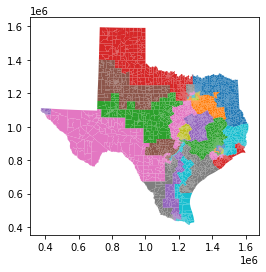

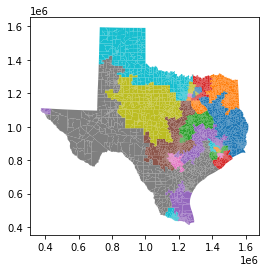

In [18]:
for partition in chain.with_progress_bar():
    #plots and prints every 100th map, helpful also for tracking progress
    if(i%100==0):
        partition.plot()
        plt.savefig("mapstep"+str(i)+".png")
    #store the results from all elections
    election_data.loc[i] = {election.name: sorted(partition[election.name].percents("Democratic")) for election in elections}
    #calculate the proportion non-white VAP in each district
    demo_data.loc[i] = {(partition["VAP"][key] - partition["WVAP"][key])/partition["VAP"][key] for key in partition["population"] }
    #calculate the proportion Hispanic VAP in each district
    HVAP_data.loc[i] = {partition["HISPVAP"][key]/partition["VAP"][key] for key in partition["population"] }
    #calculate the proportion Black VAP in each district
    BVAP_data.loc[i] = {partition["BVAP"][key]/partition["VAP"][key] for key in partition["population"] }
    #add an array of gini scores 
    gini.append([metrics.partisan_gini(partition[election.name]) for election in elections])
    i = i+1

## Analysis

**el** is a variable that stores the name of the election we would like to analyze, here the 2016 Presidential race, but you can change it to any of the Election names above. Here we extract that particular election data in a form suitable for plotting

In [19]:
HVAP_data.head()
#demo_data.head()

,HISPVAP
0,"{0.6577338879037727, 0.29474352866444337, 0.30..."
1,"{0.6577338879037727, 0.29474352866444337, 0.30..."
2,"{0.6577338879037727, 0.29474352866444337, 0.30..."
3,"{0.6577338879037727, 0.29474352866444337, 0.30..."
4,"{0.6577338879037727, 0.29474352866444337, 0.54..."


In [34]:
el = "PRES16"

num_dist = len(election_data[el].iloc[0])

percents = []

for i in range(0,n):
    #fills in election information for chosen election in plan i
    percents.append(sorted(election_data[el].loc[i][j] for j in range(0,num_dist))) 

percents = numpy.asarray(percents)

In [35]:
percents

array([[0.17417408, 0.19689824, 0.22414626, ..., 0.79300755, 0.81228329,
        0.81480705],
       [0.17417408, 0.19689824, 0.22414626, ..., 0.79300755, 0.81228329,
        0.81480705],
       [0.17417408, 0.19689824, 0.22414626, ..., 0.77139699, 0.81228329,
        0.81480705],
       ...,
       [0.19138997, 0.22494345, 0.22565263, ..., 0.70486084, 0.71440551,
        0.73308881],
       [0.19138997, 0.22494345, 0.22565263, ..., 0.70486084, 0.71440551,
        0.73308881],
       [0.19138997, 0.22494345, 0.22565263, ..., 0.70486084, 0.71440551,
        0.73308881]])

The following code processes minority voting age population as a percent of total voting age population in each district in each partition

In [36]:
mvap = []
hvap = []
bvap = []
districts_m = []
districts_h = []
districts_b = []

for i in range(0,n):
    #calculates the number of districts in plan i with MVAP proportion
    M = numpy.array(list(demo_data["MVAP"][i]))
    H = numpy.array(list(HVAP_data["HISPVAP"][i]))
    B = numpy.array(list(BVAP_data["BVAP"][i]))
    mvap.append(sorted(M))
    hvap.append(sorted(H))
    bvap.append(sorted(B))
    M = (M+0.5).astype('int')
    #calculates the number of districts in plan i with HVAP proportion > 60%
    H = (H+0.4).astype('int')
    B = (B+0.6).astype('int')
    districts_m.append(sum(M))
    districts_h.append(sum(H))
    districts_b.append(sum(B))

mvap = numpy.asarray(mvap)
hvap = numpy.asarray(hvap)
bvap = numpy.asarray(bvap)
gini = numpy.asarray(gini)
gini.T


array([[0.06589929, 0.06476005, 0.06674268, ..., 0.03056713, 0.03068429,
        0.03068402],
       [0.07780919, 0.07688536, 0.07852236, ..., 0.03976164, 0.03986144,
        0.03985681],
       [0.07821214, 0.076898  , 0.07897554, ..., 0.04361698, 0.04373996,
        0.04373722],
       ...,
       [0.08419829, 0.08318891, 0.08469146, ..., 0.04173908, 0.04183772,
        0.04183019],
       [0.05097846, 0.04992215, 0.05059542, ..., 0.02735271, 0.02737602,
        0.02736206],
       [0.03925453,        nan,        nan, ...,        nan,        nan,
               nan]])

In [37]:
mvap

array([[0.22875965, 0.2649415 , 0.28416597, ..., 0.82972909, 0.8516338 ,
        0.86057449],
       [0.22875965, 0.2649415 , 0.28416597, ..., 0.82972909, 0.8516338 ,
        0.86057449],
       [0.22875965, 0.2649415 , 0.28416597, ..., 0.82972909, 0.86017083,
        0.86057449],
       ...,
       [0.23916593, 0.26999498, 0.28476641, ..., 0.82884978, 0.86013713,
        0.89677464],
       [0.23916593, 0.26999498, 0.28476641, ..., 0.82884978, 0.86013713,
        0.89677464],
       [0.23916593, 0.26999498, 0.28476641, ..., 0.82884978, 0.86013713,
        0.89677464]])

Next we plot the election results, here a boxplot of Democratic vote percentage.

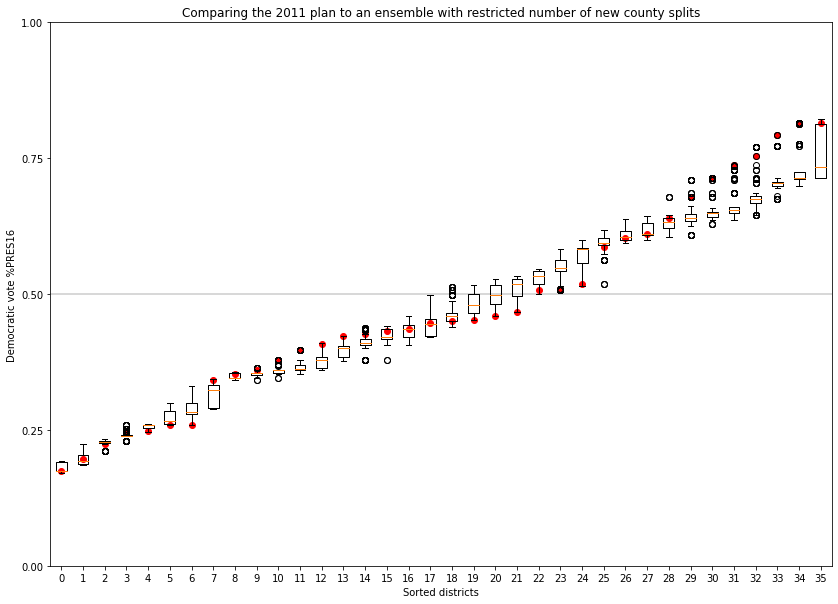

In [38]:
fig, ax = plt.subplots(figsize=(14, 10))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
#pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
#plt.boxplot(pt_asarray)

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)


percents.T
plt.plot(percents[0], "ro")
plt.boxplot(percents,positions=range(0, len(percents[0])))

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble with restricted number of new county splits")
ax.set_ylabel("Democratic vote %"+el)
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.savefig("Dem"+el+".png")
#this command outputs a figure and clears the plot
plt.show()



Now we plot a boxplot for the non-white VAP

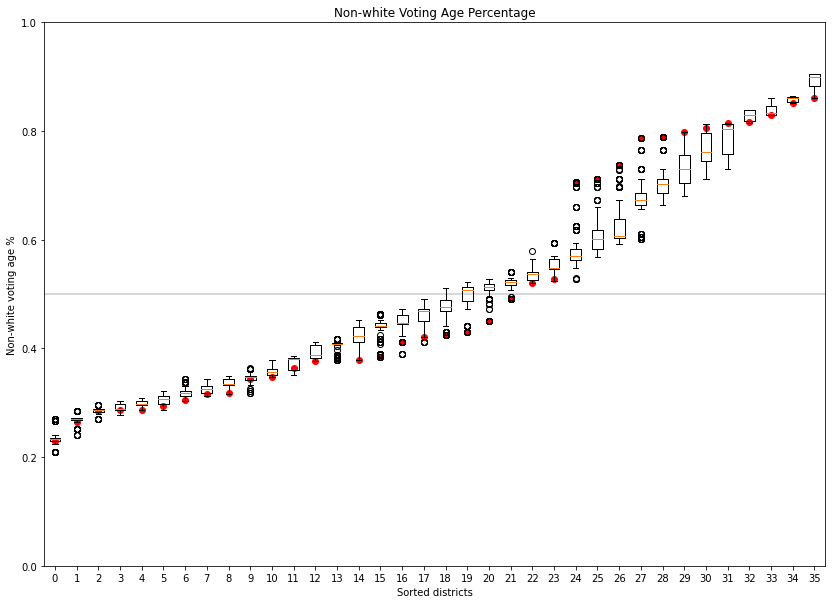

In [39]:
fig, ax = plt.subplots(figsize=(14,10))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
#pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
#plt.boxplot(pt_asarray)

# Draw initial plan's Non-white VAP %s (.iloc[0] gives the first row)

mvap.T


plt.plot(mvap[0], "ro")
plt.boxplot(mvap, positions=range(0, len(mvap[0])))

# Annotate
ax.set_title("Non-white Voting Age Percentage")
ax.set_ylabel("Non-white voting age %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig("MVAPboxplot.png")
#this command outputs a figure and clears the plot
plt.show()

And other boxplot of the Hispanic VAP

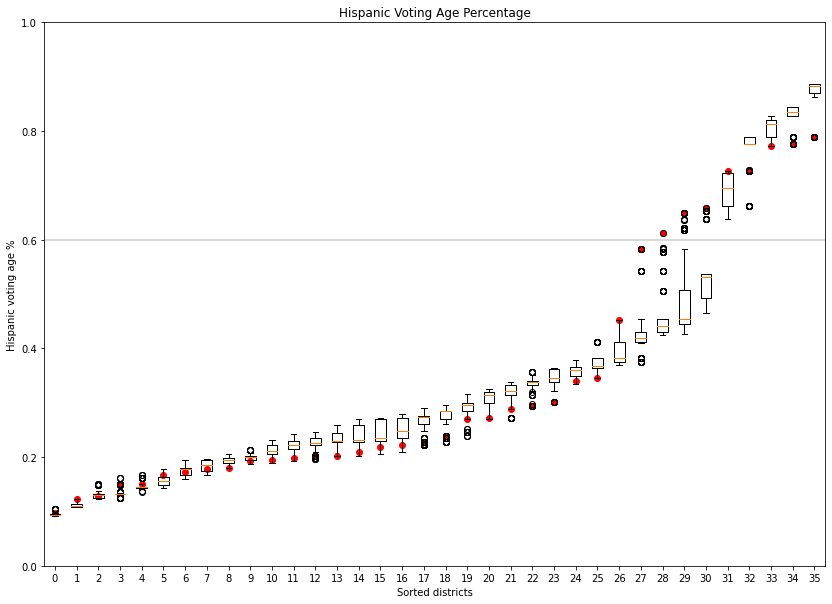

In [40]:
fig, ax = plt.subplots(figsize=(14,10))

# Draw 50% line
ax.axhline(0.6, color="#cccccc")

# Draw boxplot
#pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
#plt.boxplot(pt_asarray)

# Draw initial plan's Hispanic VAP %s (.iloc[0] gives the first row)
hvap.T
plt.plot(hvap[0], "ro")
plt.boxplot(hvap, positions=range(0, len(hvap[0])))

# Annotate
ax.set_title("Hispanic Voting Age Percentage")
ax.set_ylabel("Hispanic voting age %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig("HVAPboxplot.png")
#this command outputs a figure and clears the plot
plt.show()

And the boxplot of the Black VAP

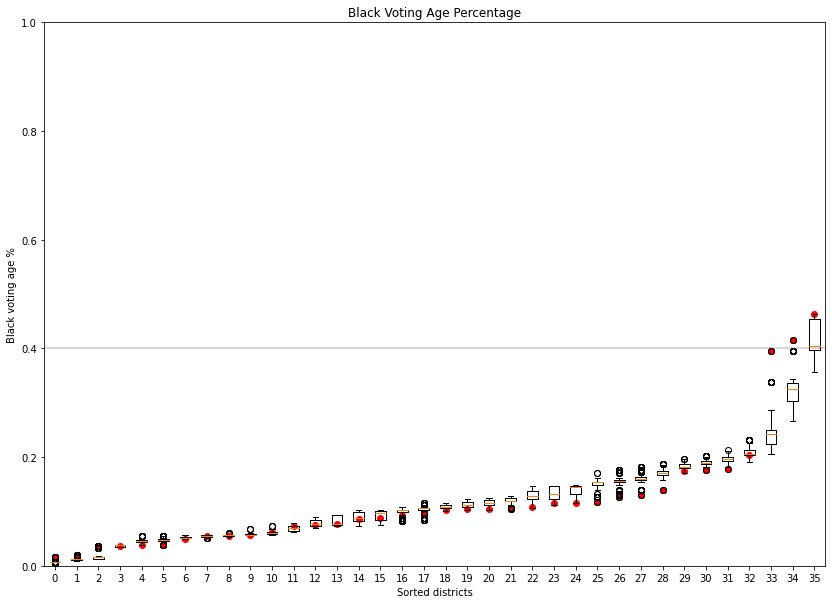

In [41]:
fig, ax = plt.subplots(figsize=(14, 10))

# Draw 40% line
ax.axhline(0.4, color="#cccccc")

# Draw boxplot
#pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
#plt.boxplot(pt_asarray)

# Draw initial plan's Black VAP %s (.iloc[0] gives the first row)
bvap.T
plt.plot(bvap[0], "ro")
plt.boxplot(bvap, positions=range(0, len(bvap[0])))

# Annotate
ax.set_title("Black Voting Age Percentage")
ax.set_ylabel("Black voting age %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig("BVAPboxplot.png")
#this command outputs a figure and clears the plot
plt.show()

And we can also plot the non-white VAP

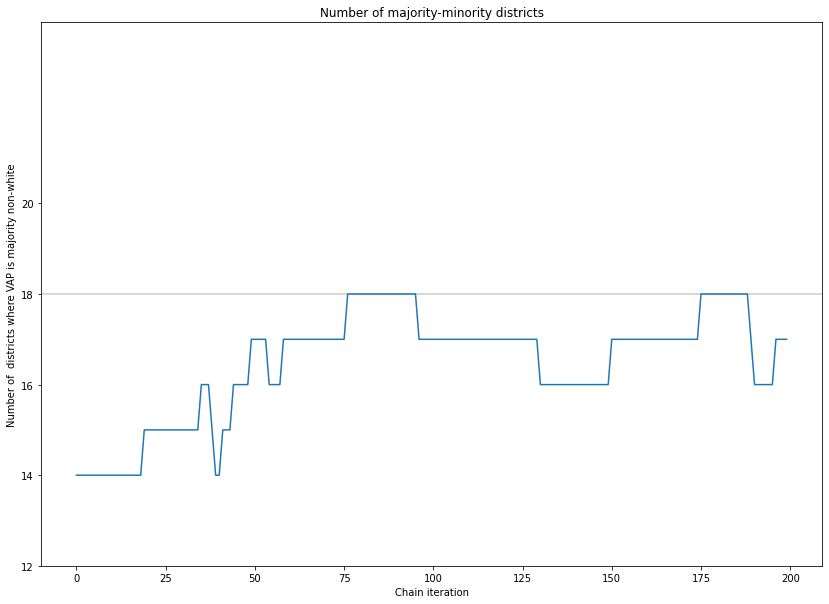

In [42]:
fig, ax = plt.subplots(figsize=(14, 10))

# Draw 50% line
ax.axhline(18, color="#cccccc")

# Draw boxplot
# pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
plt.plot(districts_m)

# Annotate
ax.set_title("Number of majority-minority districts")
ax.set_ylabel("Number of  districts where VAP is majority non-white")
ax.set_xlabel("Chain iteration")
ax.set_ylim(12, 24)
ax.set_yticks([12,14,16,18,20])

plt.savefig("nonwhiteVAP.png")

#this command outputs a figure and clears the plot
plt.show()

Plot Hispanic VAP

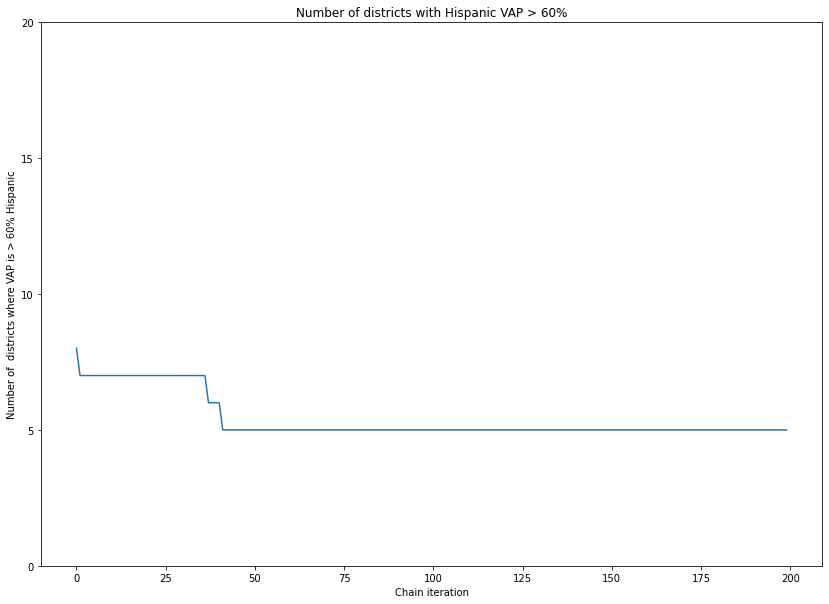

In [43]:
fig, ax = plt.subplots(figsize=(14, 10))

# Draw 50% line
#ax.axhline(18, color="#cccccc")

# Draw boxplot
# pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
plt.plot(districts_h)

# Annotate
ax.set_title("Number of districts with Hispanic VAP > 60%")
ax.set_ylabel("Number of  districts where VAP is > 60% Hispanic")
ax.set_xlabel("Chain iteration")
ax.set_ylim(0, 20)
ax.set_yticks([0,5,10,15,20])

plt.savefig("HispVAP.png")

#this command outputs a figure and clears the plot
plt.show()

Black Voting Age Populatino plot

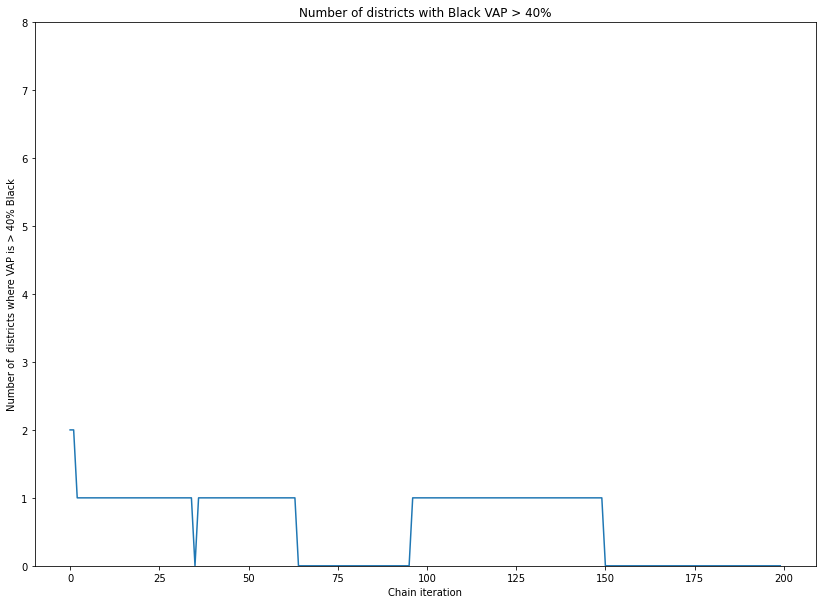

In [44]:
fig, ax = plt.subplots(figsize=(14, 10))

# Draw 50% line
#ax.axhline(18, color="#cccccc")

# Draw boxplot
# pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
plt.plot(districts_b)

# Annotate
ax.set_title("Number of districts with Black VAP > 40%")
ax.set_ylabel("Number of  districts where VAP is > 40% Black")
ax.set_xlabel("Chain iteration")
ax.set_ylim(0, 8)
ax.set_yticks([0,1,2,3,4,5,6,7,8])

plt.savefig("BlackVAP.png")

#this command outputs a figure and clears the plot
plt.show()

Partisan gini scores

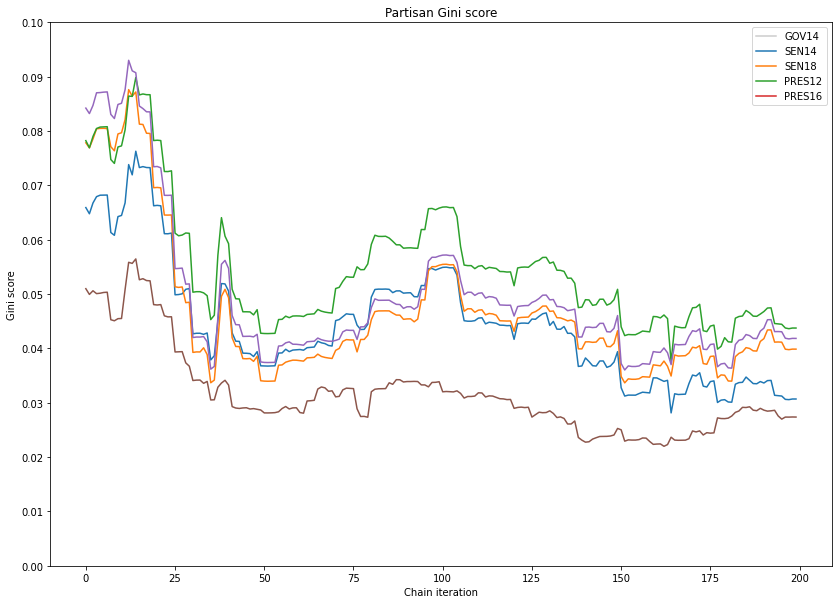

In [45]:
fig, ax = plt.subplots(figsize=(14, 10))

# Draw 50% line
ax.axhline(18, color="#cccccc")

# Draw boxplot
# pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
plt.plot(gini)


# Annotate
ax.set_title("Partisan Gini score")
ax.set_ylabel("Gini score")
ax.set_xlabel("Chain iteration")
ax.set_ylim(0,0.1)
ax.set_yticks([0,0.01,.02,.03,.04,.05,.06,.07,.08,.09,.1])

ax.legend(['GOV14','SEN14','SEN18','PRES12','PRES16'])

plt.savefig("Gini.png")

#this command outputs a figure and clears the plot
plt.show()

Gini Score Histogram

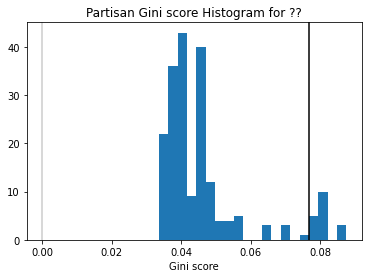

In [46]:
gini[:,1]
#fig, ax = np.histogram(gini[:,1])
plt.hist(gini[:,1], bins = 20)

# Draw 50% line
plt.axvline(0, color="#cccccc")
plt.axvline(gini.item(1,1), color='k')
# Annotate
plt.title("Partisan Gini score Histogram for ??")
plt.xlabel("Gini score")
#ax.set_xlabel("Chain iteration")

plt.show()